In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats

In [3]:
original_data = pd.read_table('results_renamed.tsv')

/tmp/ipykernel_7266/3535976908.py:1: DtypeWarning: Columns (0,1,3,5,6,7,9,12,13,14,15,16,17,18,20,22,24,25,28,29,30,34,35,44,53) have mixed types. Specify dtype option on import or set low_memory=False.
  original_data = pd.read_table('results_renamed.tsv')


In [4]:
data = original_data.copy()

In [5]:
label_freq_columns = (
    data.loc[:, data.columns.str.endswith("label_frequency_estimates_")]
    .map(lambda x: np.fromstring(x[1:-1], sep=",") if isinstance(x, str) else x)
)

data["label_freq"] = label_freq_columns.apply(
    lambda s: np.nan if s.isna().all() else s.loc[s.first_valid_index()],
    axis=1,
)
display(data["label_freq"].iloc[40:60])


40    [0.9892717308953974, 0.955411236465236, 0.9841...
41    [0.9935575456635936, 0.9568323556457584, 0.982...
42    [0.9909454036449018, 0.9439453621838395, 0.984...
43    [0.9901758222793468, 0.9313461070283305, 0.992...
44                                                  NaN
45    [0.3748365410863873, 0.3144704628041314, 0.314...
46    [0.9782943396998618, 0.9795693879836882, 0.980...
47    [0.9816852815396397, 0.9750189375488455, 0.977...
48    [0.9863942719844271, 0.9879272819905515, 0.982...
49    [0.9941032916472188, 0.9755160495152632, 0.979...
50    [0.9865767879975544, 0.9877804714587454, 0.973...
51    [0.9771704369206863, 0.9904237483346402, 0.968...
52    [0.9890267875511116, 0.9889733365553771, 0.970...
53    [0.9833048749193614, 0.9929726285155556, 0.975...
54    [0.9904369306762979, 0.9829856819960708, 0.972...
55                                                  NaN
56    [0.2918227760082664, 0.35998650858944975, 0.36...
57    [0.2918227760082664, 0.35998650858944975, 

In [6]:
data["avg_label_freq"] = data["label_freq"].copy()
data.loc[~data.avg_label_freq.isna(), "avg_label_freq"] = (
    data.loc[~data.avg_label_freq.isna(), "avg_label_freq"].map(lambda x: x.mean())
)
data["avg_label_freq"].iloc[40:60]

40     0.95947
41     0.96316
42    0.961122
43    0.963665
44         NaN
45      0.3092
46     0.94038
47    0.945209
48     0.95989
49    0.959468
50    0.956096
51     0.95649
52    0.963391
53    0.962404
54      0.9644
55         NaN
56    0.281794
57    0.281794
58    0.281794
59    0.281794
Name: avg_label_freq, dtype: object

In [7]:
data = data.loc[data.level.astype(str).str.match(r"^\d+$")]
data.loc[:, "level"] = data.loc[:, "level"].astype(int)

In [8]:
data["estimator.name"] = data["original_estimator_name"] + "__" + data["wrapper.name"].astype(str)
data = (
    data.set_index([
        "cv.fold", "original_estimator_name", "dataset.name",
        "avg_label_freq", "level",
    ])
    .rename_axis(["fold", "estimator", "dataset", "avg_label_freq", "level"])
)
score_columns_mask = data.columns.str.match(r"results\.(test|train).*")
data = data.loc[:, score_columns_mask]

In [9]:
metric = (
    data.columns#[score_columns_mask]
    .str.removeprefix("results.")
    .str.removeprefix("train_")
    .str.removeprefix("test_")
    .str.removesuffix("_internal")
    .str.removesuffix("_oob")
    .str.removesuffix("_masked")
    .rename("metric")
    # .to_series()
    # .set_axis(expected_best.index)
)

data.columns = pd.MultiIndex.from_tuples(
    ((m, s.replace("_" + m, "").removeprefix("results."))
    for m, s in zip(metric, data.columns)),
    names=("metric", "scorer"),
)

In [10]:
data = data.sort_index(axis=1)

In [11]:
filtered_data = data.loc[:, pd.IndexSlice[["neg_hamming_loss_micro", "average_precision_micro", "roc_auc_micro"], :]]
filtered_data = filtered_data.filter(like="cascade_proba", axis=0)

In [12]:
filtered_data.reset_index().estimator.value_counts()

estimator
cascade_proba__90    935
cascade_proba__70    935
cascade_proba        935
cascade_proba__50    935
Name: count, dtype: int64

scorer
train_internal        0.794545
train_oob_internal    0.810909
dtype: float64


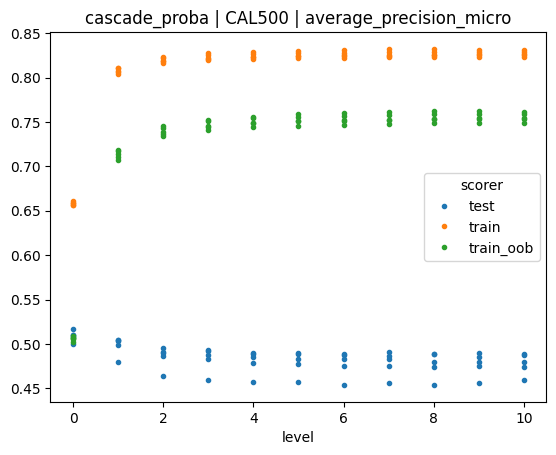

In [13]:
for gname, g in filtered_data.groupby(level=["estimator", "dataset"]):
    for gname2, g2 in g.T.groupby(level="metric"):
        g2 = g2.T.droplevel("metric", axis=1).reset_index().sort_values("level")
        # g2[g2["cv.fold"] == 2].plot(  # NOTE: Each fold results are drastically different
        g2.plot(
            x="level",
            y=["test", "train", "train_oob"],
            title=f"{' | '.join(gname)} | {gname2}",
            style=".",
        )

        print(
            g2.groupby("fold").apply(
                lambda x: x[["train_internal", "train_oob_internal"]].corrwith(
                    g2.test, method="spearman", numeric_only=True
                )
            ).abs().mean()
        )
        break
    break

In [14]:
allsets = (
    filtered_data.stack(["metric", "scorer"])
    .groupby(level=["estimator", "dataset", "fold", "metric", "scorer"])
    .rank(pct=True)  # Rank by cascade level
    .groupby(level=["estimator", "dataset", "metric", "scorer", "level"])
    .mean()  # Average over folds
)
allsets

estimator          dataset  metric                   scorer              level
cascade_proba      CAL500   average_precision_micro  test                0        1.000000
                                                                         1        0.909091
                                                                         2        0.781818
                                                                         3        0.745455
                                                                         4        0.527273
                                                                                    ...   
cascade_proba__90  yeast    roc_auc_micro            train_oob_internal  6        0.581818
                                                                         7        0.472727
                                                                         8        0.400000
                                                                         9        0.600000
           

,estimator,dataset,metric,scorer,level,0
0,cascade_proba,CAL500,average_precision_micro,test,0,1.000000
1,cascade_proba,CAL500,average_precision_micro,test,1,0.909091
2,cascade_proba,CAL500,average_precision_micro,test,2,0.781818
3,cascade_proba,CAL500,average_precision_micro,test,3,0.745455
4,cascade_proba,CAL500,average_precision_micro,test,4,0.527273
...,...,...,...,...,...,...
1117,cascade_proba,yeast,average_precision_micro,train_oob_internal,6,0.672727
1118,cascade_proba,yeast,average_precision_micro,train_oob_internal,7,0.872727
1119,cascade_proba,yeast,average_precision_micro,train_oob_internal,8,0.854545
1120,cascade_proba,yeast,average_precision_micro,train_oob_internal,9,0.927273


/home/pedro/mestrado/biomal_repo/scripts/cascade_forests/env/lib/python3.11/site-packages/seaborn/categorical.py:3370: UserWarning: 35.3% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/home/pedro/mestrado/biomal_repo/scripts/cascade_forests/env/lib/python3.11/site-packages/seaborn/categorical.py:3370: UserWarning: 17.6% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/home/pedro/mestrado/biomal_repo/scripts/cascade_forests/env/lib/python3.11/site-packages/seaborn/categorical.py:3370: UserWarning: 29.4% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/home/pedro/mestrado/biomal_repo/scripts/cascade_forests/env/lib/python3.11/site-packages/seaborn/categorical.py:3370: UserWarning: 23.5% of the points cannot be placed; you may want to d

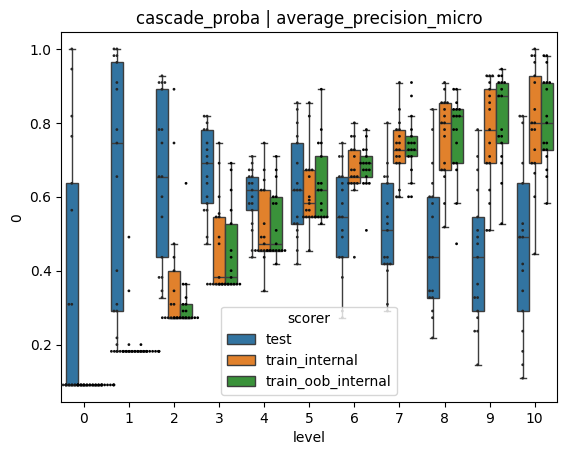

,estimator,dataset,metric,scorer,level,0
0,cascade_proba,CAL500,neg_hamming_loss_micro,test,0,0.963636
1,cascade_proba,CAL500,neg_hamming_loss_micro,test,1,0.945455
2,cascade_proba,CAL500,neg_hamming_loss_micro,test,2,0.818182
3,cascade_proba,CAL500,neg_hamming_loss_micro,test,3,0.672727
4,cascade_proba,CAL500,neg_hamming_loss_micro,test,4,0.400000
...,...,...,...,...,...,...
1117,cascade_proba,yeast,neg_hamming_loss_micro,train_oob_internal,6,0.636364
1118,cascade_proba,yeast,neg_hamming_loss_micro,train_oob_internal,7,0.790909
1119,cascade_proba,yeast,neg_hamming_loss_micro,train_oob_internal,8,0.863636
1120,cascade_proba,yeast,neg_hamming_loss_micro,train_oob_internal,9,0.827273


/home/pedro/mestrado/biomal_repo/scripts/cascade_forests/env/lib/python3.11/site-packages/seaborn/categorical.py:3370: UserWarning: 35.3% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/home/pedro/mestrado/biomal_repo/scripts/cascade_forests/env/lib/python3.11/site-packages/seaborn/categorical.py:3370: UserWarning: 5.9% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/home/pedro/mestrado/biomal_repo/scripts/cascade_forests/env/lib/python3.11/site-packages/seaborn/categorical.py:3370: UserWarning: 23.5% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)


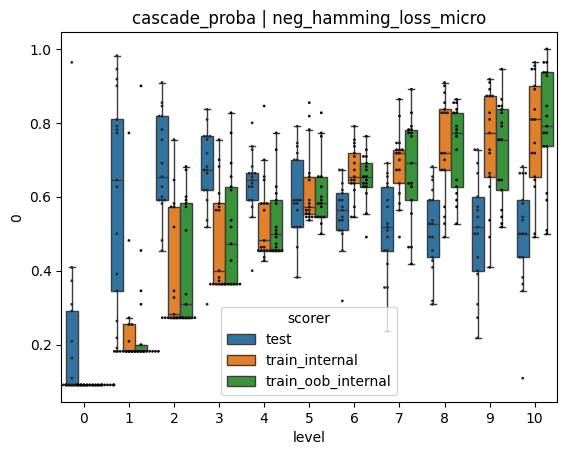

,estimator,dataset,metric,scorer,level,0
0,cascade_proba,CAL500,roc_auc_micro,test,0,1.000000
1,cascade_proba,CAL500,roc_auc_micro,test,1,0.909091
2,cascade_proba,CAL500,roc_auc_micro,test,2,0.818182
3,cascade_proba,CAL500,roc_auc_micro,test,3,0.727273
4,cascade_proba,CAL500,roc_auc_micro,test,4,0.581818
...,...,...,...,...,...,...
1117,cascade_proba,yeast,roc_auc_micro,train_oob_internal,6,0.709091
1118,cascade_proba,yeast,roc_auc_micro,train_oob_internal,7,0.909091
1119,cascade_proba,yeast,roc_auc_micro,train_oob_internal,8,0.800000
1120,cascade_proba,yeast,roc_auc_micro,train_oob_internal,9,0.872727


/home/pedro/mestrado/biomal_repo/scripts/cascade_forests/env/lib/python3.11/site-packages/seaborn/categorical.py:3370: UserWarning: 35.3% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/home/pedro/mestrado/biomal_repo/scripts/cascade_forests/env/lib/python3.11/site-packages/seaborn/categorical.py:3370: UserWarning: 17.6% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/home/pedro/mestrado/biomal_repo/scripts/cascade_forests/env/lib/python3.11/site-packages/seaborn/categorical.py:3370: UserWarning: 23.5% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/home/pedro/mestrado/biomal_repo/scripts/cascade_forests/env/lib/python3.11/site-packages/seaborn/categorical.py:3370: UserWarning: 5.9% of the points cannot be placed; you may want to de

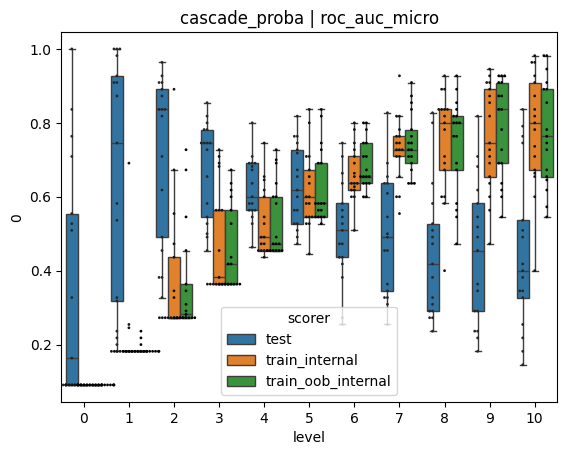

,estimator,dataset,metric,scorer,level,0
0,cascade_proba__50,CAL500,average_precision_micro,test,0,1.000000
1,cascade_proba__50,CAL500,average_precision_micro,test,1,0.909091
2,cascade_proba__50,CAL500,average_precision_micro,test,2,0.818182
3,cascade_proba__50,CAL500,average_precision_micro,test,3,0.727273
4,cascade_proba__50,CAL500,average_precision_micro,test,4,0.636364
...,...,...,...,...,...,...
1304,cascade_proba__50,yeast,average_precision_micro,train_oob_internal,6,0.654545
1305,cascade_proba__50,yeast,average_precision_micro,train_oob_internal,7,0.800000
1306,cascade_proba__50,yeast,average_precision_micro,train_oob_internal,8,0.836364
1307,cascade_proba__50,yeast,average_precision_micro,train_oob_internal,9,0.836364


/home/pedro/mestrado/biomal_repo/scripts/cascade_forests/env/lib/python3.11/site-packages/seaborn/categorical.py:3370: UserWarning: 35.3% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/home/pedro/mestrado/biomal_repo/scripts/cascade_forests/env/lib/python3.11/site-packages/seaborn/categorical.py:3370: UserWarning: 5.9% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/home/pedro/mestrado/biomal_repo/scripts/cascade_forests/env/lib/python3.11/site-packages/seaborn/categorical.py:3370: UserWarning: 23.5% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)


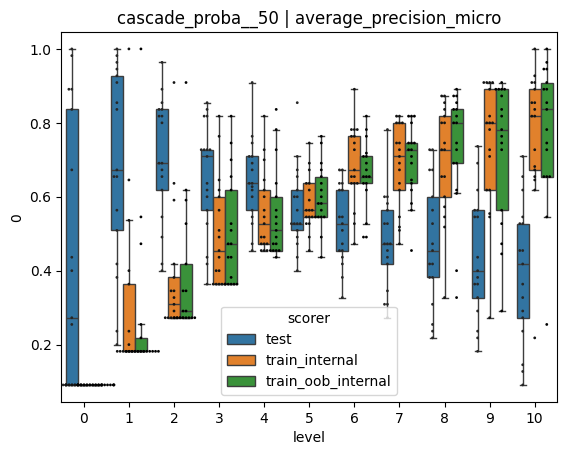

,estimator,dataset,metric,scorer,level,0
0,cascade_proba__50,CAL500,neg_hamming_loss_micro,test,0,0.090909
1,cascade_proba__50,CAL500,neg_hamming_loss_micro,test,1,0.236364
2,cascade_proba__50,CAL500,neg_hamming_loss_micro,test,2,0.427273
3,cascade_proba__50,CAL500,neg_hamming_loss_micro,test,3,0.454545
4,cascade_proba__50,CAL500,neg_hamming_loss_micro,test,4,0.609091
...,...,...,...,...,...,...
1304,cascade_proba__50,yeast,neg_hamming_loss_micro,train_oob_internal,6,0.618182
1305,cascade_proba__50,yeast,neg_hamming_loss_micro,train_oob_internal,7,0.790909
1306,cascade_proba__50,yeast,neg_hamming_loss_micro,train_oob_internal,8,0.818182
1307,cascade_proba__50,yeast,neg_hamming_loss_micro,train_oob_internal,9,0.890909


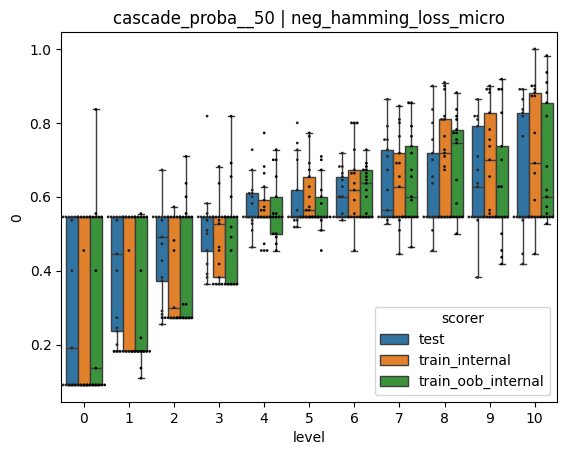

,estimator,dataset,metric,scorer,level,0
0,cascade_proba__50,CAL500,roc_auc_micro,test,0,0.963636
1,cascade_proba__50,CAL500,roc_auc_micro,test,1,0.945455
2,cascade_proba__50,CAL500,roc_auc_micro,test,2,0.818182
3,cascade_proba__50,CAL500,roc_auc_micro,test,3,0.727273
4,cascade_proba__50,CAL500,roc_auc_micro,test,4,0.581818
...,...,...,...,...,...,...
1304,cascade_proba__50,yeast,roc_auc_micro,train_oob_internal,6,0.709091
1305,cascade_proba__50,yeast,roc_auc_micro,train_oob_internal,7,0.690909
1306,cascade_proba__50,yeast,roc_auc_micro,train_oob_internal,8,0.672727
1307,cascade_proba__50,yeast,roc_auc_micro,train_oob_internal,9,0.727273


/home/pedro/mestrado/biomal_repo/scripts/cascade_forests/env/lib/python3.11/site-packages/seaborn/categorical.py:3370: UserWarning: 35.3% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/home/pedro/mestrado/biomal_repo/scripts/cascade_forests/env/lib/python3.11/site-packages/seaborn/categorical.py:3370: UserWarning: 5.9% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/home/pedro/mestrado/biomal_repo/scripts/cascade_forests/env/lib/python3.11/site-packages/seaborn/categorical.py:3370: UserWarning: 17.6% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/home/pedro/mestrado/biomal_repo/scripts/cascade_forests/env/lib/python3.11/site-packages/seaborn/categorical.py:3370: UserWarning: 23.5% of the points cannot be placed; you may want to de

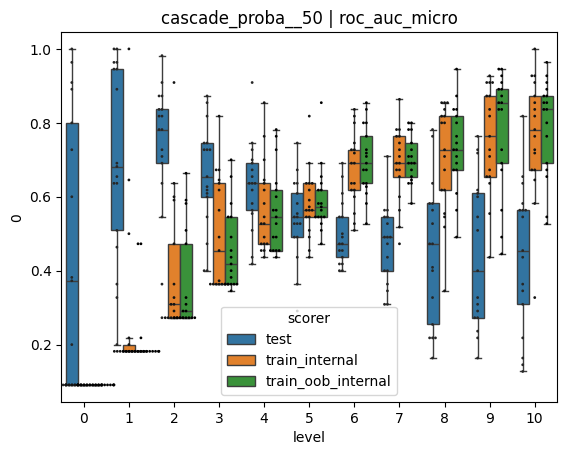

In [15]:
count = 0
for gname, g in allsets.groupby(level=["estimator", "metric"]):#, "scorer"]):
# for gname, g in allsets.groupby(level=["estimator.name", "metric", "scorer"]):
    g = g.reset_index()
    g = g[g["scorer"].isin(("test", "train_internal", "train_oob_internal"))]
    display(g)
    sns.boxplot(g, x="level", y=0, hue="scorer", showfliers=False)
    sns.swarmplot(g, x="level", y=0, hue="scorer", palette="dark:k", dodge=True, size=2, legend=False)
    # sns.boxplot(g, x="level", y=0, hue="scorer")
    plt.title(f"{' | '.join(gname)}")
    plt.show()
    count += 1
    if count == 6: break

In [44]:
imputation_scores = data.loc[
    data.index.get_level_values("level") > 0,
    pd.IndexSlice[
        ["tp_micro", "tn_micro", "fp_micro", "fn_micro"],
        ["train", "train_masked"],
    ]
]
imputation_scores = imputation_scores.filter(like="cascade_lc_proba", axis=0)
imputation_scores = imputation_scores.dropna(how="any")
imputation_scores

metric                                                  tp_micro               \
scorer                                                     train train_masked   
fold estimator            dataset avg_label_freq level                          
0    cascade_lc_proba__50 yeast   0.561069       1      0.134434     0.007796   
                                                 2      0.148485     0.013989   
                                                 3      0.155473     0.019446   
                                                 4      0.159813     0.023343   
                                                 5      0.162167     0.026375   
...                                                          ...          ...   
4    cascade_lc_proba__70 flags   0.347914       6      0.344156     0.228571   
                                                 7      0.343074     0.224675   
                                                 8      0.345238     0.227273   
                                                 9      0.344156     0.225974   
                                                 10     0.343074     0.225974   

metric                                                  tn_micro               \
scorer                                                     train train_masked   
fold estimator            dataset avg_label_freq level                          
0    cascade_lc_proba__50 yeast   0.561069       1      0.670590     0.789606   
                                                 2      0.637083     0.750152   
                                                 3      0.629873     0.741663   
                                                 4      0.626011     0.737116   
                                                 5      0.622885     0.733434   
...                                                          ...          ...   
4    cascade_lc_proba__70 flags   0.347914       6      0.333333     0.400000   
                                                 7      0.331169     0.397403   
                                                 8      0.331169     0.397403   
                                                 9      0.332251     0.398701   
                                                 10     0.332251     0.398701   

metric                                                  fp_micro               \
scorer                                                     train train_masked   
fold estimator            dataset avg_label_freq level                          
0    cascade_lc_proba__50 yeast   0.561069       1     -0.028137    -0.033131   
                                                 2     -0.061645    -0.072586   
                                                 3     -0.068854    -0.081074   
                                                 4     -0.072716    -0.085621   
                                                 5     -0.075842    -0.089303   
...                                                          ...          ...   
4    cascade_lc_proba__70 flags   0.347914       6     -0.119048    -0.142857   
                                                 7     -0.121212    -0.145455   
                                                 8     -0.121212    -0.145455   
                                                 9     -0.120130    -0.144156   
                                                 10    -0.120130    -0.144156   

metric                                                  fn_micro               
scorer                                                     train train_masked  
fold estimator            dataset avg_label_freq level                         
0    cascade_lc_proba__50 yeast   0.561069       1     -0.166838    -0.169467  
                                                 2     -0.152788    -0.163274  
                                                 3     -0.145800    -0.157817  
                                                 4     -0.141459    -0.153919  
                                   

('cascade_lc_proba__50', 'CAL500')


metric,level,tp_micro,tn_micro,fp_micro,fn_micro
0,1,0.210230,0.284523,0.481459,0.023789
1,2,0.213921,0.268053,0.497929,0.020098
2,3,0.213502,0.270150,0.495832,0.020517
3,4,0.213391,0.270976,0.495005,0.020628
4,5,0.213394,0.271365,0.494616,0.020624
5,6,0.213255,0.271805,0.494177,0.020763
6,7,0.213284,0.272162,0.493820,0.020735
7,8,0.213314,0.272374,0.493607,0.020704
8,9,0.213334,0.272210,0.493772,0.020685
9,10,0.213335,0.272463,0.493519,0.020684


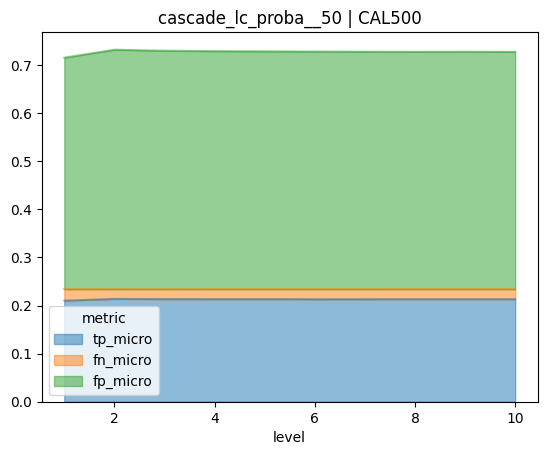

('cascade_lc_proba__50', 'CHD_49')


metric,level,tp_micro,tn_micro,fp_micro,fn_micro
0,1,0.239635,0.481171,0.008557,0.270636
1,2,0.259456,0.478919,0.010809,0.250815
2,3,0.263599,0.477928,0.011800,0.246672
3,4,0.267203,0.477658,0.012070,0.243068
4,5,0.269095,0.477388,0.012341,0.241176
5,6,0.269546,0.476848,0.012880,0.240725
6,7,0.270267,0.476488,0.013241,0.240004
7,8,0.270086,0.476308,0.013421,0.240185
8,9,0.271078,0.476308,0.013421,0.239194
9,10,0.270808,0.476038,0.013691,0.239464


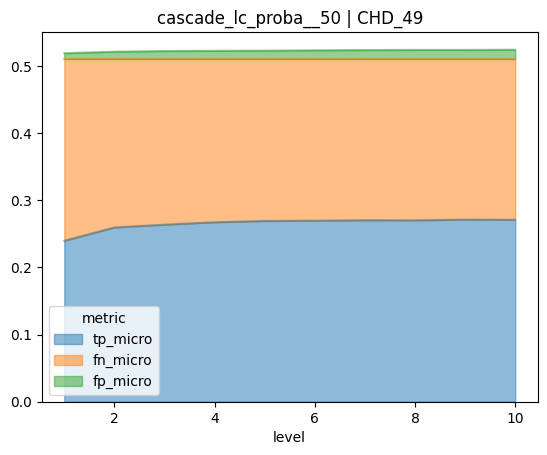

('cascade_lc_proba__50', 'Gram_negative')


metric,level,tp_micro,tn_micro,fp_micro,fn_micro
0,1,0.105513,0.824742,0.003322,0.066422
1,2,0.107669,0.823785,0.004280,0.064266
2,3,0.107999,0.823336,0.004729,0.063936
3,4,0.107878,0.823036,0.005029,0.064057
4,5,0.108089,0.822947,0.005118,0.063846
5,6,0.107789,0.822767,0.005298,0.064146
6,7,0.107909,0.822707,0.005357,0.064026
7,8,0.108118,0.822707,0.005358,0.063817
8,9,0.108506,0.822468,0.005597,0.063429
9,10,0.107909,0.822707,0.005358,0.064027


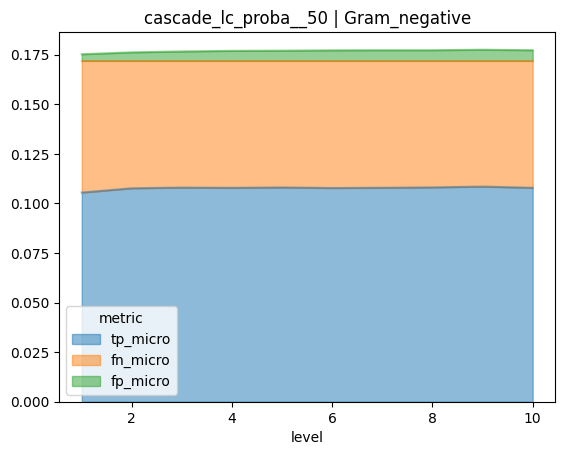

In [50]:
count = 0
for gname, g in imputation_scores.groupby(level=["estimator", "dataset"]):
    print(gname)
    g = g.loc[:, pd.IndexSlice[:, "train"]].droplevel("scorer", axis=1)
    g = g.groupby(level=["level"]).mean().reset_index()
    g = g.abs()  # fn and fp are negative to enforce greater-is-better
    display(g)
    g.plot.area(
        x="level",
        y=["tp_micro", "fn_micro", "fp_micro"],  #, "tn_micro"],
        title=f"{' | '.join(gname)}",
        stacked=True,
        alpha=0.5,
    )
    plt.show()
    count += 1
    if count == 3: break